# Load libraries

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import plot_roc_curve
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier

___

# Import data

To check for class imbalances

In [11]:
# load data
df_ml = pd.read_csv('../datasets/ML.csv')

In [12]:
# count samples within each class
num_depression = df_ml['is_depression'].sum()
num_anxiety = len(df_ml) - num_depression

# print counts
print(f"Number of depression examples: {num_depression}")
print(f"Number of anxiety examples: {num_anxiety}")

Number of depression examples: 1964
Number of anxiety examples: 1994


The number of depression examples (1964) and anxiety examples (1994) are relatively close, so it is not a severe class imbalance. 

In [13]:
# check columns
df_ml.columns

Index(['id', 'created_utc', 'title', 'is_self', 'selftext', 'score',
       'upvote_ratio', 'num_comments', 'permalink', 'author', 'distinguished',
       'post_length', 'title_selftext_comb', 'title_selftext_comb_clean',
       'title_selftext_comb_clean_lem', 'selftext_clean', 'sentiment',
       'is_depression'],
      dtype='object')

___

# Commence machine learning

## Set a baseline comparison

- Baseline comparison is set to provide a benchmark for evaluating the performance of the model. If the model does not outperform the baseline, the approach or data has to be re-evaluated.
- Baseline accuracy can be calculated by always predicting the majority class in the dataset. Reason being is that it represents the performance of a naive model that does not learn anything from the data.
- If the model cannot outperform the naive baseline, then it is not learning anything useful from the data.

In [14]:
# calculate the percentage of "depression" posts
depression_pct = df_ml["is_depression"].mean() * 100

In [15]:
# calculate the percentage of "anxiety" posts
anxiety_pct = 100 - depression_pct

In [16]:
# set majority class as baseline (e.g. always predict the majority class)
if depression_pct > anxiety_pct:
    baseline = depression_pct
else:
    baseline = anxiety_pct

In [17]:
print(f"Baseline accuracy: {baseline:.2f}%")

Baseline accuracy: 50.38%


## Model training and scoring

In [18]:
# train,test,split
X_train, X_test, y_train, y_test = train_test_split(df_ml['title_selftext_comb_clean_lem'], df_ml['is_depression'], test_size=0.2, random_state=42)

- Vectorizer is a tool that helps computers process text by turning it into a numerical form.
- TF-IDF is a way to give more weight to important and less common words in a text document, while giving less weight to common words. 
- The TF-IDF vectorizer uses this method to turn text into numbers.

In [19]:
# vectorize using TfidfVectorizer the text data using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

- MultinomialNB (Naive Bayes) is a type of algorithm used in machine learning for text classification tasks.
- Based on the Bayes theorem and assumes that each feature is independent of the others.
- Algorithm counts the frequency of words in each category, then uses these frequencies to predict which category a new text belongs to. 

In [20]:
# Train the Naive Bayes classifier
nb_clf = MultinomialNB()
nb_scores = cross_val_score(nb_clf, X_train_vect, y_train, cv=5)
nb_clf.fit(X_train_vect, y_train)

MultinomialNB()

- Logistic regression is an algorithm used in machine learning for classification tasks.
- Statistical method that estimates the probability of a binary or categorical outcome based on one or more independent variables.
- It tries to find the relationship between the input variables and the output variable by fitting a logistic function to the data.

In [21]:
# Train the logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000)
lr_scores = cross_val_score(lr_clf, X_train_vect, y_train, cv=5)
lr_clf.fit(X_train_vect, y_train)

LogisticRegression(max_iter=1000)

- Cross-validation evaluates the performance of a model on an independent data set.
- It splits the original data into two parts: a training set used to build the model, and a validation set used to test the model's performance.

In [22]:
# calculate scores for Naive Bayes model
nb_pred = nb_clf.predict(X_test_vect)
nb_acc = accuracy_score(y_test, nb_pred)
nb_prec = precision_score(y_test, nb_pred)
nb_rec = recall_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)

In [23]:
# calculate scores for Logistic Regression model
lr_pred = lr_clf.predict(X_test_vect)
lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)
lr_rec = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

## Confusion matrix

NameError: name 'lr_cm' is not defined

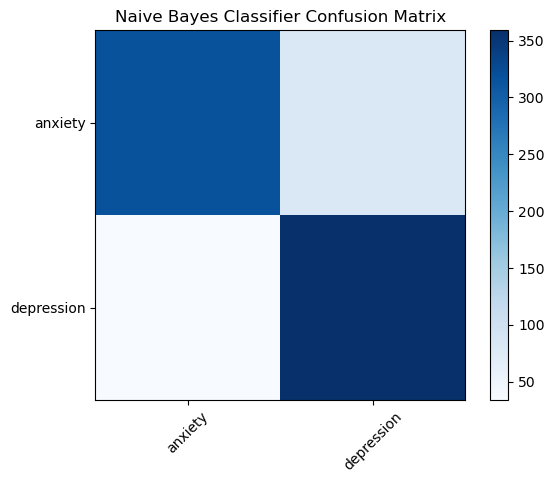

In [24]:
# calculate confusion matrix
nb_cm = confusion_matrix(y_test, nb_pred)

# define classes
classes = np.array(['anxiety', 'depression'])

# plot confusion matrix
plt.imshow(nb_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Naive Bayes Classifier Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# label
thresh = nb_cm.max() / 2.0
for i, j in itertools.product(range(nb_cm.shape[0]), range(nb_cm.shape[1])):
    plt.text(j, i, nb_cm[i, j],
             horizontalalignment="center",
             color="white" if lr_cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tick_params(axis='both', which='major', labelsize=14, pad=10)
plt.show()

- TP (True Positive) = 317: This means that 317 posts were correctly classified as belonging to the r/anxiety subreddit.

- FP (False Positive) = 82: This means that 82 posts were incorrectly classified as belonging to the r/anxiety subreddit when they actually belonged to the r/depression subreddit.

- FN (False Negative) = 34: This means that 34 posts were incorrectly classified as belonging to the r/depression subreddit when they actually belonged to the r/anxiety subreddit.

- TN (True Negative) = 359: This means that 359 posts were correctly classified as belonging to the r/depression subreddit.

In [ ]:
# calculate confusion matrix
lr_cm = confusion_matrix(y_test, lr_pred)

# define classes
classes = np.array(['anxiety', 'depression'])

# plot matrix
plt.imshow(lr_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Logistic Regression Classifier Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# label
thresh = lr_cm.max() / 2.0
for i, j in itertools.product(range(lr_cm.shape[0]), range(lr_cm.shape[1])):
    plt.text(j, i, lr_cm[i, j],
             horizontalalignment="center",
             color="white" if lr_cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tick_params(axis='both', which='major', labelsize=14, pad=10)
plt.show()

- TP (True Positive) = 358: This means that 358 posts were correctly classified as belonging to the r/anxiety subreddit.

- FP (False Positive) = 41: This means that 41 posts were incorrectly classified as belonging to the r/anxiety subreddit when they actually belonged to the r/depression subreddit.

- FN (False Negative) = 41: This means that 41 posts were incorrectly classified as belonging to the r/depression subreddit when they actually belonged to the r/anxiety subreddit.

- TN (True Negative) = 352: This means that 352 posts were correctly classified as belonging to the r/depression subreddit.

In [ ]:
print("Naive Bayes Classifier:")
print("Cross-validation scores:", nb_scores)
print("Mean cross-validation score:", nb_scores.mean())
print("Accuracy:", nb_acc)
print("Precision:", nb_prec)
print("Recall:", nb_rec)
print("F1 score:", nb_f1)
print("\nLogistic Regression Classifier:")
print("Cross-validation scores:", lr_scores)
print("Mean cross-validation score:", lr_scores.mean())
print("Accuracy:", lr_acc)
print("Precision:", lr_prec)
print("Recall:", lr_rec)
print("F1 score:", lr_f1)

***Scoring Description***: </br>
- Cross-validation score: </br>
    - Average score of a model on a set of test data using cross-validation.
    - It is used to evaluate the performance of a model on new data, and it provides an estimate of how well the model is likely to perform on unseen data.

- Accuracy: </br>
    - Used to measure the overall performance of a model.
    - It measures the proportion of correctly classified data points to the total number of data points.
    - However, accuracy is not always the best measure of a model's performance, especially when the data is imbalanced or the costs of false positives and false negatives are different (For the dataset, this is not an issue).

- Precision: </br>
    - Measures the proportion of true positives (correctly identified positives) to the total number of predicted positives.
    - It is useful when the cost of false positives is high, and we want to minimize the number of false positives.

- Recall: </br>
    - Measures the proportion of true positives to the total number of actual positives.
    - It is useful when the cost of false negatives is high, and we want to minimize the number of false negatives.

- F1 score: </br>
    - Harmonic mean of precision and recall, and it provides a single score that combines both metrics.
    - It is a useful metric when we want to balance precision and recall, and we want to find a trade-off between them.
    - The F1 score ranges from 0 to 1, with 1 being the best possible score.

***Score Prioritisation***:
- In the context of mental health classification between r/depression and r/anxiety with the goal of helping individuals receive appropriate help and support from the community, both recall (sensitivity) and precision are equally important.

***Results***: </br>
- The goal is to classify posts between r/depression and r/anxiety and direct individuals to the appropriate community for help and support, both `recall (sensitivity)` and `precision` metrics are important.

- The logistic regression classifier has an equal precision and recall score of 0.896, which means it is equally good at identifying both positive (r/depression) and negative (r/anxiety) instances. Therefore, it is likely to perform better than the Naive Bayes classifier, which has a lower precision score of 0.814 and a higher recall score of 0.913.

- This means that the Naive Bayes classifier may identify more posts as positive (r/depression) than the logistic regression classifier, but at the cost of misclassifying some negative (r/anxiety) instances.

- Therefore, the logistic regression classifier is likely to be a better choice for this specific problem and context as it is more balanced in identifying both r/depression and r/anxiety posts, while still maintaining high accuracy and a good balance between precision and recall.

***But Naive Bayes has a higher recall score?*** </br>
- We also want to balance recall with other metrics such as precision, accuracy, and F1 score.

- The Naive Bayes classifier has a lower precision score (0.814) compared to the logistic regression classifier (0.896), indicating that it may have more false positives, where a post is classified as being about depression (r/depression) but is actually about anxiety (r/anxiety). This could potentially direct individuals to the wrong community for help and support, which could be harmful.

- While the Naive Bayes classifier may have a higher recall score, the logistic regression classifier's balanced performance across all metrics, and specifically its equal precision and recall score, makes it a better choice for this specific problem and context of classifying posts between r/depression and r/anxiety and directing individuals to the appropriate community for help and support.

## ROC curve

- The ROC curve is a plot of the true positive rate (sensitivity) against the false positive rate (1-specificity) for different threshold values.

- The true positive rate is the proportion of actual positives that are correctly identified as positives, and the false positive rate is the proportion of actual negatives that are incorrectly identified as positives.

- Useful for evaluating the performance of a binary classifier over a range of possible classification thresholds.

- A good classifier should have a ROC curve that is closer to the upper left corner of the plot, which represents high true positive rates and low false positive rates. A diagonal line from the bottom left to the top right of the plot represents a random guess classifier.

- Area under the ROC curve (AUC) is also a useful metric for evaluating the overall performance of a classifier. A perfect classifier will have an AUC of 1, while a random guess classifier will have an AUC of 0.5. A classifier with an AUC greater than 0.5 but less than 1 is better than random guessing, but not perfect.

- A random guess classifier is useful as a baseline model for classification tasks, especially in cases where the classes are imbalanced or the data is noisy. By comparing the performance of more complex models such as Naive Bayes or Logistic Regression to the random guess classifier, we can determine whether the models are adding any value to the classification task.

- In summary, the ROC curve helps to visualize the trade-off between true positive and false positive rates for different threshold values, and the AUC provides a single number summary of the classifier's overall performance.

In [ ]:
# Train a random guess classifier that predicts classes at random
random_guess_clf = DummyClassifier(strategy='uniform', random_state=42)
random_guess_clf.fit(X_train_vect, y_train)

In [ ]:
# Plot the ROC curve for the Naive Bayes classifier
nb_disp = plot_roc_curve(nb_clf, X_test_vect, y_test)

# Plot the ROC curve for the logistic regression classifier
lr_disp = plot_roc_curve(lr_clf, X_test_vect, y_test, ax=nb_disp.ax_)

# Plot the ROC curve for the random guess classifier
random_guess_disp = plot_roc_curve(random_guess_clf, X_test_vect, y_test, ax=nb_disp.ax_, linestyle='--')

# Calculate and display the AUC value for the Naive Bayes classifier
nb_auc = auc(nb_disp.fpr, nb_disp.tpr)
plt.text(0.7, 0.3, f'Naive Bayes AUC = {nb_auc:.2f}', ha='center', va='center', color='blue')

# Calculate and display the AUC value for the logistic regression classifier
lr_auc = auc(lr_disp.fpr, lr_disp.tpr)
plt.text(0.7, 0.4, f'Logistic Regression AUC = {lr_auc:.2f}', ha='center', va='center', color='orange')

# Add a legend and show the plot
lr_disp.ax_.legend(['Naive Bayes', 'Logistic Regression', 'AUC'])
plt.show()

***Results***:</br>
- Logistic Regression model has a larger area below the curve (i.e., a higher AUC value), this generally indicates that the Logistic Regression model is performing better than the Naive Bayes model in terms of its ability to distinguish between the positive and negative classes.

- The larger area under the ROC curve for the Logistic Regression model suggests that it has a better balance between true positives and false positives compared to the Naive Bayes model.

- The higher AUC value suggests that the Logistic Regression model is better at correctly identifying positive cases while minimizing false positives (i.e., higher precision) and at correctly identifying both positive and negative cases (i.e., higher recall).

## Demo

In [ ]:
def clean_text(text):
    # Rreplace underscores and replace with spaces
    text = text.replace('_', ' ')

    # lowercase the texts
    text = text.lower()
    
    # remove numbers using regex that match one or more digits
    text = re.sub(r'\d+', '', text)
    
    # remove hypens and split the hyphenated words into individual words
    text = re.sub(r"-", " ", text)
    
    # remove apostrophes and split into individual words
    text = re.sub(r"'", "", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    
    # remove punctuations using regex that match one or more punctuation characters
    text = re.sub(r'[^\w\s]+', '', text)
    
    # remove links
    words = text.split(' ')
    words_to_sub = [w for w in words if 'http' in w]

    if words_to_sub:
        for w in words_to_sub:
            new_word = re.sub('http.*', '', w)
            text = re.sub(w, new_word, text)
    
    # remove whitespaces using regex that match one or more whitespace characters
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [ ]:
def lemmatize(text):
    # instantiate the lemmatizer object
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    
    # remove stopwords from tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # lemmatize the tokens in the list of filtered tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # join back into a string to return lemmatized text
    lemmatized_text = " ".join(lemmatized_tokens)
    
    return lemmatized_text

In [ ]:
input_text = "GovTech"

In [ ]:
cleaned_text = clean_text(input_text)

In [ ]:
cleaned_lem_text = lemmatize(cleaned_text)

In [ ]:
# Transform the preprocessed text
transformed_text = vectorizer.transform([cleaned_lem_text])

In [ ]:
# Predict the class of the input text
predicted_class = lr_clf.predict(transformed_text)[0]

In [ ]:
if predicted_class == 0:
    predicted_subreddit = "r/anxiety"
else:
    predicted_subreddit = "r/depression"

In [ ]:
print(f"The recommended subreddit for the input text '{input_text}' to be posted in is {predicted_subreddit}")